#  This script aims to develop a clustering:
- load profile
- compute microparameters
- make clustering on the raw signal and microparameters
- compute macroparameters for the clusters
- output the profile as caaml (hopefulls with the document.export_caaml functionality)

check hat the document.export_caaml holds the individual layer boundaries??

--> lets go!

In [1]:
import sys
sys.path.append('D:\\SMP_stability\\snowmicropyn')
print(sys.path)

['C:\\Users\\gerling\\.conda\\envs\\smp\\python312.zip', 'C:\\Users\\gerling\\.conda\\envs\\smp\\DLLs', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib', 'C:\\Users\\gerling\\.conda\\envs\\smp', '', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib\\site-packages', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib\\site-packages\\win32', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib\\site-packages\\win32\\lib', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib\\site-packages\\Pythonwin', 'C:\\Users\\gerling\\.conda\\envs\\smp\\Lib\\site-packages\\setuptools\\_vendor', 'D:\\SMP_stability\\snowmicropyn']


In [2]:
import snowmicropyn as smpyn
import pathlib

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.signal import savgol_filter as savgol
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

## 1. load profile

In [3]:
#prof = Profile.load('snowmicropyn/examples/profiles/S37M0876.pnt')
prof = smpyn.Profile.load('.pnt_data\\190110_BUN\\SMP\\FILE0245.pnt') 

## 2. compute microparameters

In [4]:
samples = prof.samples_within_snowpack()
parameterization = "CR2020"
# Prebpare derivatives:
param = smpyn.derivatives.parameterizations[parameterization]
param.overlap = 50
param.window_size = 2

loewe2012_df = smpyn.loewe2012.calc(samples, param.window_size, param.overlap)
derivatives = loewe2012_df
derivatives = derivatives.merge(param.calc_from_loewe2012(loewe2012_df))

## 3. make clustering


### Defining the features and weights

In [5]:
# Combine absolute values and derivatives into a feature matrix
features = np.column_stack((derivatives.L2012_lambda.values ,derivatives.L2012_f0.values ,derivatives.L2012_delta.values, derivatives.L2012_L.values, derivatives.CR2020_ssa.values, derivatives.CR2020_density.values))
x = derivatives.distance.values

weights = np.array([1,3,1,5,3,1])  # feature weighting, more weight on force, density and SSA
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features = scaled_features * weights

### Estimate the Optimal Number of Clusters with Elbow-Method

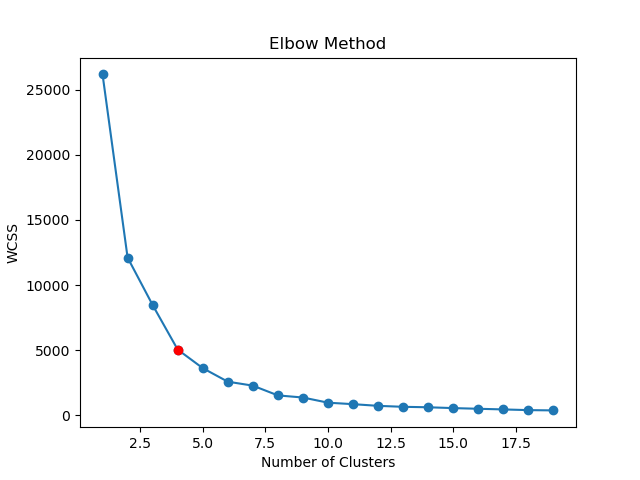

optimal_number_clusters: 4


In [6]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from scipy.spatial.distance import euclidean
from scipy.spatial import ConvexHull
import warnings
warnings.filterwarnings('ignore')
%matplotlib widget
plt.figure()

# Calculate WCSS for different numbers of clusters
wcss = []
min_cluster,max_cluster = 1, 20
cluster_range = np.arange(1,20)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Straight line connecting endpoints
line_start = np.array([cluster_range[0], wcss[0]])
line_end = np.array([cluster_range[-1], wcss[-1]])
# Calculate distances from each point to the line
distances = []
for i in range(len(cluster_range)):
    point = np.array([cluster_range[i], wcss[i]])
    distance = np.abs(np.cross(line_end-line_start, line_start-point)) / np.linalg.norm(line_end-line_start)
    distances.append(distance)

# Find the point of maximum distance
kink_index = np.argmax(distances)
kink_x = cluster_range[kink_index]
kink_y = wcss[kink_index]
# Plot the Elbow Method
plt.plot(cluster_range, wcss, marker='o')
plt.plot(kink_x,kink_y,marker="o",c="r")
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

opt_number_clusters = kink_x
print("optimal_number_clusters: " + str(opt_number_clusters))

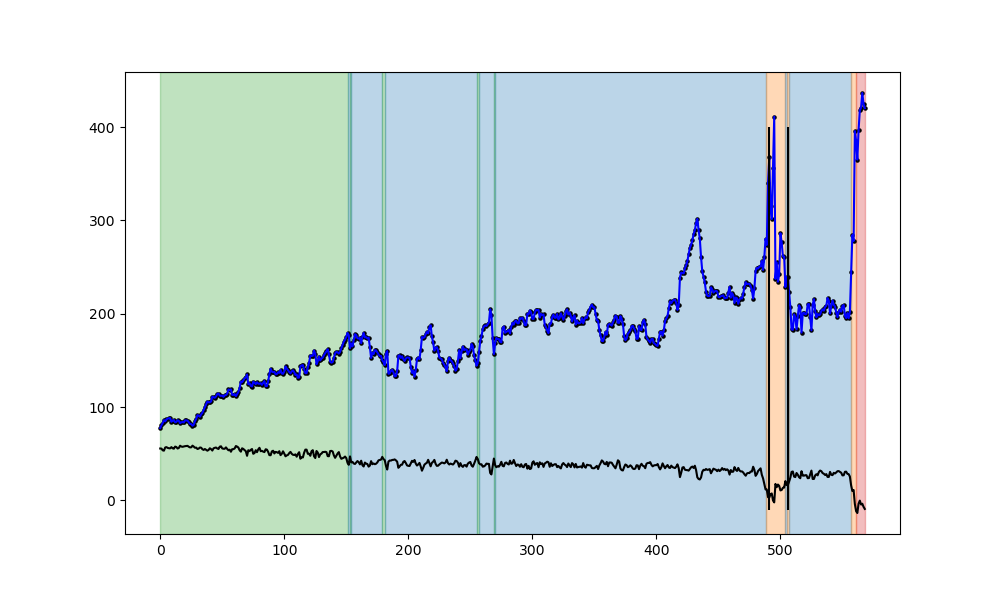

In [7]:
# Use KMeans to cluster based on both features
additional_clusters = 0 # weak layers are sometimes thin and just little weaker as the rest of the layer so we allow more clusters than "necessary"
n_clusters = opt_number_clusters + additional_clusters # Adjust the number of blocks
kmeans = KMeans(n_clusters=n_clusters, random_state=42, )
labels = kmeans.fit_predict(scaled_features)
derivatives["cluster_id"] = labels

# Find boundaries based on clusters
boundaries = [x[0]]  # Start with the first point
for i in range(1, len(labels)):
    if labels[i] != labels[i - 1]:  # If the cluster label changes
        boundaries.append(x[i])
boundaries.append(x[-1])  # Add the last point

# Compute average values in each block
block_values = []
for i in range(len(boundaries) - 1):
    start, end = boundaries[i], boundaries[i + 1]
    mask = (x >= start) & (x < end)
    block_avg = np.mean(derivatives.CR2020_density[mask])
    block_values.append(block_avg)


plt.figure(figsize=(10, 6))
plt.plot(x, derivatives.CR2020_density, label="CR2020_density", color="blue")
plt.plot(x, derivatives.CR2020_ssa, label="CR2020_ssa", color="k")
for i in range(len(boundaries) - 1):
    col = f"C{int(derivatives.loc[derivatives['distance'] == boundaries[i], 'cluster_id'].iloc[0])}"
    plt.axvspan(boundaries[i], boundaries[i + 1], color=col, alpha=0.3, label=f"Block {i+1}")
plt.scatter(x, derivatives.CR2020_density, color="black", s=5, label="Data Points")
plt.vlines(prof.markers["wl_t"]-prof.markers["surface"],-10,400,colors="k")
plt.vlines(prof.markers["wl_b"]-prof.markers["surface"],-10,400,colors="k")

### from cluster_id  to layer_id 

In [8]:
derivatives['layer_id'] = (derivatives['cluster_id'] != derivatives['cluster_id'].shift()).cumsum()

## make means and go to caaml exporting


In [9]:
layered_derivatives = derivatives.groupby('layer_id').mean()
layered_derivatives["distance"] = derivatives.groupby('layer_id').max().distance # distance is the lower boundary in the snowpack, 0 is surface

In [11]:
# Prepend a row with zero distance (copy of the second row)
df_with_zeros = pd.concat([layered_derivatives.iloc[:1],layered_derivatives.iloc[:1], layered_derivatives.iloc[1:]], ignore_index=True)
df_with_zeros.distance.iloc[:1] = 0

In [48]:
from snowmicropyn.serialize import caaml
from snowmicropyn.ai.grain_classifier import grain_classifier

outfile = None
export_settings = {'export_grainshape':True, 'use_pretrained_model': True, 'trained_input_path': 'snowmicropyn/snowmicropyn/ai/trained_model_rhossa.dat'}
df = df_with_zeros

# add _smp flag to file name in order to (hopefully) not overwrite hand profiles:
stem = f'{prof._pnt_file.stem}_smp'
if outfile:
    outfile = pathlib.Path(outfile) # full file name was given
    if outfile.is_dir(): # folder name was given -> choose filename
        outfile = pathlib.Path(f'{outfile}/{stem}.caaml')
else: # no name was given --> choose full path
    outfile = prof._pnt_file.with_name(stem).with_suffix('.caaml')

grain_shapes = {}
if export_settings.get('export_grainshape', False): # start machine learning process
    classifier = grain_classifier(export_settings)
    grain_shapes = classifier.predict(df.drop(["CR2020_density","CR2020_ssa","cluster_id"],axis=1))


caaml.export(export_settings, df, grain_shapes,
    prof._pnt_file.stem, prof._timestamp, prof._smp_serial,
    prof._longitude, prof._latitude, prof._altitude, outfile)

['MFcr' 'PP' 'RG' 'RG' 'RG' 'PP' 'PP' 'PP' 'RG' 'PP' 'RG' 'IF' 'MFcr' 'IF'
 'RG' 'MFcr' 'MFcr']


### 